In [55]:
import io
import spacy
import string
import torch
import csv
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
from nltk import ngrams
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
np.random.seed(0)

## 1. Upload data

In [2]:
def data_loader(filepath):
    sen1 = []
    sen2 = []
    label = []
    with open(filepath)as file:
        f_tsv = csv.reader(file,delimiter = '\t')
        header = next(f_tsv)
        for row in f_tsv:
            sen1.append(row[0].split())
            sen2.append(row[1].split())
            if row[2] == 'contradiction':
                label.append(0.0)
            elif row[2] == 'neutral':
                label.append(1.0)
            elif row[2] == 'entailment':
                label.append(2.0)
    return sen1,sen2,label

In [7]:
train_sen1, train_sen2, train_y = data_loader('hw2_data/snli_train.tsv')
val_sen1, val_sen2, val_y = data_loader('hw2_data/snli_val.tsv')

In [3]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb') as f:
        pkl.dump(objct, f, protocol=None)
    return

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f)
    return(objct)

### Build vocabulary and take token to index

In [5]:
def build_vocab(max_vocab_size = 50000, PAD_IDX = 0,UNK_IDX = 1):
    # Returns:
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    fin = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    embedding = np.zeros((max_vocab_size+2,300))
    token2id = {'<pad>':PAD_IDX, '<unk>':UNK_IDX}
    embedding[UNK_IDX] = np.random.rand(300)
    data = {}
    for i,line in enumerate(fin):
        if i >= max_vocab_size: 
            break
        tmp = line.rstrip().split(' ')
        embedding[i+2,:] = np.array(tmp[1:])
        token2id[tmp[0]] = i+2
    return token2id,embedding

[token2id,embedding] = build_vocab()


In [4]:
embedding = pkl_loader('embedding_5w.p')
token2id = pkl_loader('token2id.p')

In [5]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        for token in tokens:
            
            if token in token2id:
                index_list.append(token2id[token])
            else:
                index_list.append(UNK_IDX)
        indices_data.append(index_list)
    return indices_data

In [8]:
train_sen1_indices = token2index_dataset(train_sen1)
train_sen2_indices = token2index_dataset(train_sen2)
val_sen1_indices = token2index_dataset(val_sen1)
val_sen2_indices = token2index_dataset(val_sen2)

In [9]:
MAX_SENTENCE_LENGTH1 = int(np.percentile([len(i) for i in train_sen1], 99))
MAX_SENTENCE_LENGTH2 = int(np.percentile([len(i) for i in train_sen2], 99))
MAX_SENTENCE_LENGTH1,MAX_SENTENCE_LENGTH2

(34, 19)

## 2.Data Loader for Pytorch

In [10]:
class SNLI_GroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1, data_list2,target_list):
        """
        @param data_list1: list of tokens in sen1
        @param data_list2: list of tokens in sen2
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH1]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH2]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1), token_idx2, len(token_idx2),label]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        length_list1.append(datum[1])
        length_list2.append(datum[3])
        label_list.append(datum[4])
        
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH1-datum[1])), 
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1),
            torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2),torch.LongTensor(label_list)]
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)


In [11]:
train_dataset = SNLI_GroupDataset(train_sen1_indices, train_sen2_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

val_dataset = SNLI_GroupDataset(val_sen1_indices, val_sen2_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

## 3. Models

### 3.1 CNN

In [12]:
class CNN_SNLI(nn.Module):
    def __init__(self,hidden_size,fc_dim,kernel_size,padding,dropout,num_classes=3,emb_dim = 300):
        super(CNN_SNLI, self).__init__()
        self.hidden_size = hidden_size
        self.fc_dim = fc_dim
        self.kernel_size = kernel_size
        self.padding = padding
        self.dropout = dropout
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding)).float()
        self.conv1 = nn.Sequential(OrderedDict([
                        ('cov1',nn.Conv1d(emb_dim, self.hidden_size, kernel_size=self.kernel_size, padding=self.padding)),
                        ('relu1',nn.ReLU()),
                        ('cov2',nn.Conv1d(self.hidden_size,self.hidden_size, kernel_size=self.kernel_size, padding=self.padding)),
                        ('relu1',nn.ReLU()),
                        ('pool1',nn.MaxPool1d(MAX_SENTENCE_LENGTH1))]))

        self.conv2 = nn.Sequential(
                        nn.Conv1d(emb_dim, self.hidden_size, kernel_size=self.kernel_size, padding=self.padding),
                        nn.ReLU(),
                        nn.Conv1d(self.hidden_size,self.hidden_size, kernel_size=self.kernel_size, padding=self.padding),
                        nn.ReLU(),
                        nn.MaxPool1d(MAX_SENTENCE_LENGTH2))
        
        self.last_layer = nn.Sequential(
                        nn.Linear(2*self.hidden_size, self.fc_dim),
                        nn.ReLU(), 
                        nn.Dropout(self.dropout),
                        nn.Linear(self.fc_dim, num_classes))
        
    def forward(self,sen1,len1,sen2,len2):
        embed1 = self.embedding(sen1).transpose(1,2)
        embed2 = self.embedding(sen2).transpose(1,2)
        hidden1 = self.conv1(embed1) 
        hidden2 = self.conv2(embed2)
        combined = torch.cat([hidden1, hidden2],dim=1)
        out = torch.sum(combined, dim=-1)
        out = self.last_layer(out)
        return out
        

In [13]:
class BRNN(nn.Module):
    def __init__(self, hidden_size,fc_dim,kernel_size,padding,dropout, num_layers = 1,num_classes = 3,emb_size = 300):
        super(BRNN,self).__init__()
        self.hidden_size = hidden_size
        #fully connected layer dimension
        self.fc_dim = fc_dim
        self.kernel_size = kernel_size
        self.padding = padding
        self.dropout = dropout
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding)).float()
        self.GRU = nn.GRU(emb_size, self.hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.linear = nn.Linear(hidden_size, num_classes)     
        self.last_layer = nn.Sequential(
                        nn.Linear(2*self.hidden_size, self.fc_dim),
                        nn.ReLU(), 
                        nn.Dropout(self.dropout),
                        nn.Linear(self.fc_dim, num_classes))
        
    def init_hidden(self, batch_size,hidden_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size,hidden_size)
        
    def forward(self,sen1,len1,sen2,len2):
        batch_size1,seq_len1 = sen1.size()
        batch_size2,seq_len2 = sen2.size()
        
        hidden1 = self.init_hidden(batch_size1,self.hidden_size)
        hidden2 = self.init_hidden(batch_size2,self.hidden_size)
        #get embedding for sen1 list and sen2 list
        embed1 = self.embedding(sen1)
        embed2 = self.embedding(sen2)
        #sort and unsort
        len_sort1,sort1 = torch.sort(len1, dim=0, descending=True)
        _,unsort1 = torch.sort(sort1, dim=0)
        len_sort2,sort2 = torch.sort(len2, dim=0, descending=True)
        _,unsort2 = torch.sort(sort2, dim=0)
        # pack padded sequence
        embed1 = embed1.index_select(0,sort1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1,  len_sort1.numpy(), batch_first=True)
        embed2 = embed2.index_select(0,sort2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2,  len_sort2.numpy(), batch_first=True)
        # GRU
        _, hidden1 = self.GRU(embed1, hidden1)
        hidden1 = hidden1.index_select(1, unsort1)
        _, hidden2 = self.GRU(embed2, hidden2)
        hidden2 = hidden2.index_select(1,unsort2)
        combined = torch.cat([hidden1, hidden2],dim=2)
        out = torch.sum(combined, dim=0)
        out = self.last_layer(out)
        return out
        

## Test and Train model / Plot

In [14]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, len1, data2, len2, label in loader:
        data_batch1, lengths_batch1, data_batch2, lengths_batch2,label_batch = data1, len1, data2, len2, label
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2,lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += label.size(0)
        correct += predicted.eq(label.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [15]:
criterion = nn.CrossEntropyLoss()
def train_model(model, learning_rate, num_epochs, model_name='BRNN'):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losslist = []
    val_acclist = []
    train_acclist = []
    for epoch in range(num_epochs):
        for i, (sen1_list, len1, sen2_list, len2, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            out = model(sen1_list, len1,sen2_list,len2)
            loss = criterion(out, label)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            if i > 0 and i % 1000 == 0:
                # validate
                train_losslist.append(loss)
                train_acclist.append(test_model(train_loader, model))
                val_acclist.append(test_model(val_loader, model))
    param_nums = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("--------------------------Model:{}--------------------------".format(model_name))
    print("Number of parameters:{}".format(param_nums))
    print("Val Accuracy:{}".format(val_acclist[-1])) 
    return train_losslist,train_acclist,val_acclist,model
    

In [16]:
def plot_curves(train_acc,train_loss,val_acc,param_name,param):
    plt.figure(figsize=(16,7))
    plt.subplot(1, 2, 1)
    for i in range(len(train_acc)):
        plt.plot(train_acc[i], label='Train Acc: '+str(param[i]))
    for i in range(len(val_acc)):
        plt.plot(val_acc[i], label='Val Acc: '+str(param[i]))
    plt.xlabel("i%1000")
    plt.ylabel("Train/Val Accuracy")
    plt.legend(loc='best')
    plt.title(param_name)
    
    plt.subplot(1, 2, 2)
    for i in range(len(train_loss)):
        plt.plot(train_loss[i], label='Train Loss: '+str(param[i]))
    plt.xlabel("i%1000")
    plt.ylabel("Train Loss")
    plt.legend(loc='best')
    plt.title(param_name) 
    plt.show()

In [17]:
def plot_curves_biparam(train_acc,train_loss,val_acc,param_name,param):
    plt.figure(figsize=(16,7))
    plt.subplot(1, 2, 1)
    for i in range(len(train_acc)):
        plt.plot(train_acc[i], label='Train Acc: [{},{}]'.format(param[i][0],param[i][1]))
    for i in range(len(val_acc)):
        plt.plot(val_acc[i], label='Val Acc: [{},{}]'.format(param[i][0],param[i][1]))
    plt.xlabel("i%1000")
    plt.ylabel("Train/Val Accuracy")
    plt.legend(loc='best')
    plt.title(param_name)
    
    plt.subplot(1, 2, 2)
    for i in range(len(train_loss)):
        plt.plot(train_loss[i], label='Train Loss: [{},{}]'.format(param[i][0],param[i][1]))
    plt.xlabel("i%1000")
    plt.ylabel("Train Loss")
    plt.legend(loc='best')
    plt.title(param_name) 
    plt.show()

## CNN performance
### Dropout

In [22]:
model = CNN_SNLI(100,50,3,1,0.3)
train_losslist,train_acclist,val_acclist,test_model = train_model(model,3e-4, 5, model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:250603
Val Accuracy:63.5


In [38]:
model = CNN_SNLI(100,50,3,1,0.1)
train_losslist1,train_acclist1,val_acclist1,test_mode11 = train_model(model,3e-4, 5, model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:250603
Val Accuracy:65.1


In [39]:
model = CNN_SNLI(100,50,3,1,0.5)
train_losslist2,train_acclist2,val_acclist2,test_model2 = train_model(model,3e-4, 5,model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:250603
Val Accuracy:65.4


In [203]:
dropout = [0.3,0.1,0.5]
train_acc=[train_acclist,train_acclist1,train_acclist2]
train_loss = [train_losslist,train_losslist1,train_losslist2]
val_acc = [val_acclist,val_acclist1,val_acclist2]


In [207]:
pkl_dumper(train_acc,'train_acc012.p')
pkl_dumper(train_loss,'train_loss012.p')
pkl_dumper(val_acc,'val_acc012.p')

In [211]:
pkl_dumper(test_model,'test_model.pkl')
pkl_dumper(test_mode11,'test_model1.pkl')
pkl_dumper(test_model2,'test_model2.pkl')

----------------------------------CNN----------------------------------


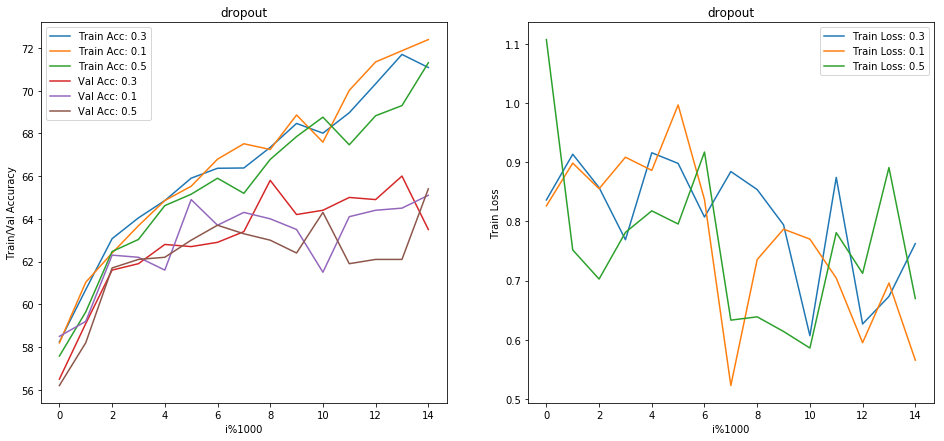

In [190]:
print("----------------------------------CNN----------------------------------")
plot_curves(train_acc,train_loss,val_acc,'dropout',dropout)

### Hidden_dim

In [48]:
model = CNN_SNLI(200,50,3,1,0.3)
train_losslist3,train_acclist3,val_acclist3,test_mode13 = train_model(model,3e-4, 5, model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:621003
Val Accuracy:66.9


In [49]:
model = CNN_SNLI(200,100,3,1,0.3)
train_losslist4,train_acclist4,val_acclist4,test_mode14 = train_model(model,3e-4, 5, model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:641203
Val Accuracy:67.2


In [212]:
hidden_dim = [[100,50],[200,50],[200,100]]
train_acc=[train_acclist,train_acclist3,train_acclist4]
train_loss = [train_losslist,train_losslist3,train_losslist4]
val_acc = [val_acclist,val_acclist3,val_acclist4]

In [213]:
pkl_dumper(train_acc,'train_acc034.p')
pkl_dumper(train_loss,'train_loss034.p')
pkl_dumper(val_acc,'val_acc034.p')

In [215]:
pkl_dumper(test_mode13,'test_model3.pkl')
pkl_dumper(test_mode14,'test_model4.pkl')

----------------------------------CNN----------------------------------


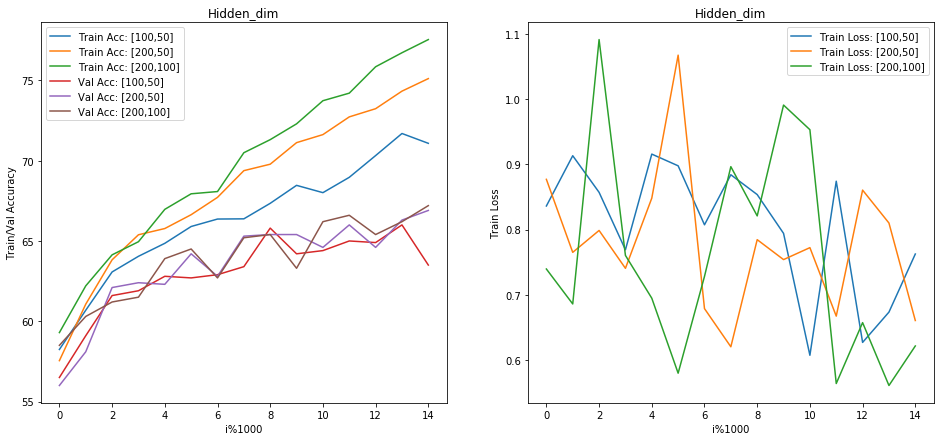

In [192]:
print("----------------------------------CNN----------------------------------")
plot_curves_biparam(train_acc,train_loss,val_acc,'Hidden_dim',hidden_dim)

### kernel_size

In [52]:
model = CNN_SNLI(200,100,5,2,0.3)
train_losslist5,train_acclist5,val_acclist5,test_mode15 = train_model(model,3e-4, 5, model_name='CNN')

--------------------------Model:CNN--------------------------
Number of parameters:1041203
Val Accuracy:65.2


In [216]:
kernel_size= [[3,1],[5,2]]
train_acc=[train_acclist4,train_acclist5]
train_loss = [train_losslist4,train_losslist5]
val_acc = [val_acclist4,val_acclist5]

In [217]:
pkl_dumper(train_acc,'train_acc45.p')
pkl_dumper(train_loss,'train_loss45.p')
pkl_dumper(val_acc,'val_acc45.p')
pkl_dumper(test_mode15,'test_model3.pkl')

----------------------------------CNN----------------------------------


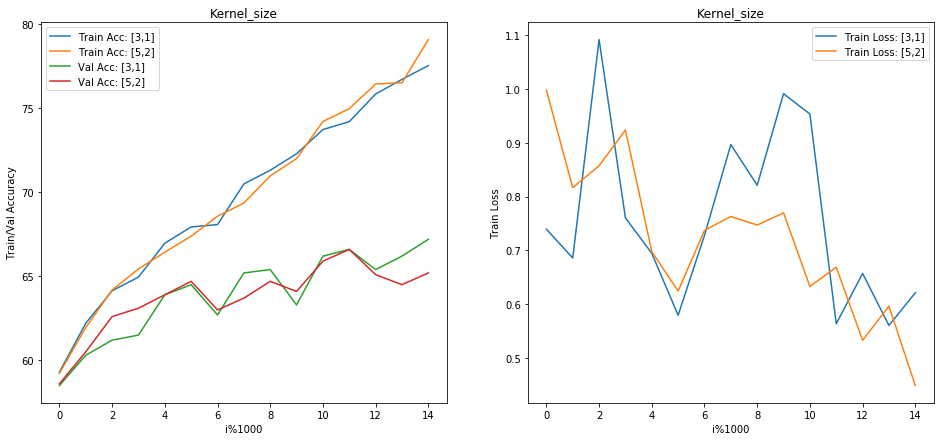

In [194]:
print("----------------------------------CNN----------------------------------")
plot_curves_biparam(train_acc,train_loss,val_acc,'Kernel_size',kernel_size)

### correct and Incorrect answer in CNN

In [30]:
def label_trans(a):
    if a == 0.0:
        return 'contradiction'
    elif a == 1.0:
        return 'neural'
    elif a == 2.0:
        return 'entailment'

In [147]:
correct = []
predicted_list = []
total = 0
test_mode14.eval()
for data1, len1, data2, len2, label in val_loader:
    outputs = F.softmax(test_mode14(data1, len1, data2, len2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct.append(predicted.numpy() == label.view_as(predicted).numpy())
    predicted_list.append(predicted.numpy())

In [148]:
predicted_list = [i for j in range(len(predicted_list)) for i in predicted_list[j] ]
correct = [i for j in range(len(correct)) for i in correct[j] ]

In [152]:
correct_list = []
incorrect_list = []
first_c = True
first_inc = True
counter_c = 0
counter_inc = 0
for i, val in enumerate(correct):
    if counter_c < 3 and val[0] == True:
        if first_c:
            print("-----------correct predictions-------------")
            first_c = False
        print('premise: {}'.format(' '.join(val_sen1[i])))
        print('hypothesis: {}'.format(' '.join(val_sen2[i])))
        print('True label: {}'.format(label_trans(val_y[i])))
        print('\t')
        counter_c += 1
    elif counter_c >= 3 and val[0] == False and counter_inc < 3:
        if first_inc:
            print("-----------incorrect predictions-------------")
            first_inc = False
        print('premise: {}'.format(' '.join(val_sen1[i])))
        print('hypothesis: {}'.format(' '.join(val_sen2[i])))
        print('True label: {}'.format(label_trans(val_y[i])))
        print('But predicted as: {}'.format(label_trans(predicted_list[i])))
        print('\t')
        counter_inc +=1
    elif counter_c >= 3 and counter_inc >= 3:
        break

-----------correct predictions-------------
premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
hypothesis: There are two women standing on the stage
True label: contradiction
	
premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis: Multiple people are on a subway together , with each of them doing their own thing .
True label: entailment
	
premise: Man in overalls with two horses .
hypothesis: a man in overalls with two horses
True label: entailment
	
-----------incorrect predictions-------------
premise: Man observes a wavelength given off by an electronic device .
hypothesis: The man is examining what wavelength is given off by the device .
True label: entailment
But predicted as: contradiction
	
premise: Two people

## BRNN Performance
### Dropout

In [195]:
model = BRNN(100,50,3,1,0.1)
train_losslist6,train_acclist6,val_acclist6,test_mode16 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:251706
Val Accuracy:67.2


In [196]:
model = BRNN(100,50,3,1,0.3)
train_losslist7,train_acclist7,val_acclist7,test_mode17 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:251706
Val Accuracy:66.0


In [197]:
model = BRNN(100,50,3,1,0.5)
train_losslist8,train_acclist8,val_acclist8,test_mode18 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:251706
Val Accuracy:67.8


----------------------------------BRNN----------------------------------


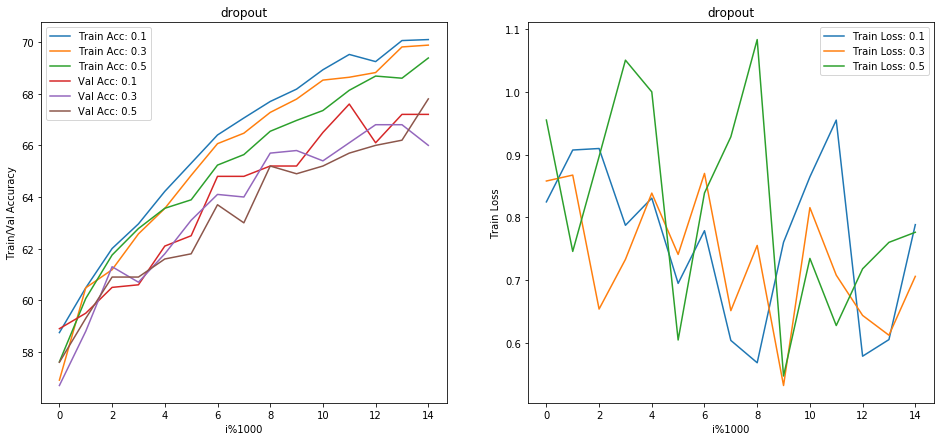

In [218]:
dropout = [0.1,0.3,0.5]
train_acc=[train_acclist6,train_acclist7,train_acclist8]
train_loss = [train_losslist6,train_losslist7,train_losslist8]
val_acc = [val_acclist6,val_acclist7,val_acclist8]
print("----------------------------------BRNN----------------------------------")
plot_curves(train_acc,train_loss,val_acc,'dropout',dropout)

In [219]:
pkl_dumper(train_acc,'train_acc678.p')
pkl_dumper(train_loss,'train_loss678.p')
pkl_dumper(val_acc,'val_acc678.p')
pkl_dumper(test_mode16,'test_model6.pkl')
pkl_dumper(test_mode17,'test_model7.pkl')
pkl_dumper(test_mode18,'test_model8.pkl')

### Hidden_dim

In [19]:
model = BRNN(200,50,3,1,0.5)
train_losslist9,train_acclist9,val_acclist9,test_mode19 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:623206
Val Accuracy:68.2


In [20]:
model = BRNN(200,100,3,1,0.5)
train_losslist10,train_acclist10,val_acclist10,test_mode110 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:643406
Val Accuracy:68.7


In [22]:
train_acclist8 = pkl_loader('train_acc678.p')[-1]
train_losslist8 = pkl_loader('train_loss678.p')[-1]
val_acclist8 = pkl_loader('val_acc678.p')[-1]

----------------------------------BRNN----------------------------------


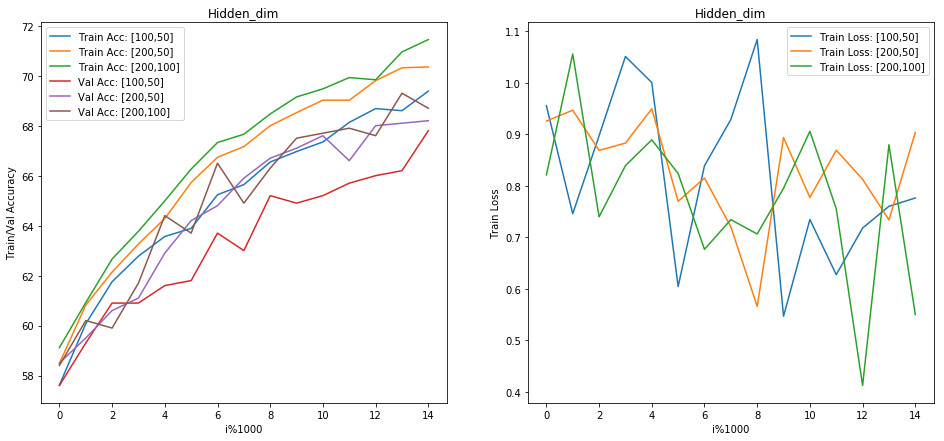

In [23]:
hidden_dim = [[100,50],[200,50],[200,100]]
train_acc=[train_acclist8,train_acclist9,train_acclist10]
train_loss = [train_losslist8,train_losslist9,train_losslist10]
val_acc = [val_acclist8,val_acclist9,val_acclist10]
print("----------------------------------BRNN----------------------------------")
plot_curves_biparam(train_acc,train_loss,val_acc,'Hidden_dim',hidden_dim)

### Kernel_size

In [24]:
model = BRNN(200,100,5,2,0.3)
train_losslist11,train_acclist11,val_acclist11,test_mode111 = train_model(model,3e-4, 5)

--------------------------Model:BRNN--------------------------
Number of parameters:643406
Val Accuracy:69.7


In [69]:
pkl_dumper(test_mode111,'test_mode111.pkl')

In [25]:
kernel_size= [[3,1],[5,2]]
train_acc=[train_acclist10,train_acclist11]
train_loss = [train_losslist10,train_losslist11]
val_acc = [val_acclist10,val_acclist11]

----------------------------------BRNN----------------------------------


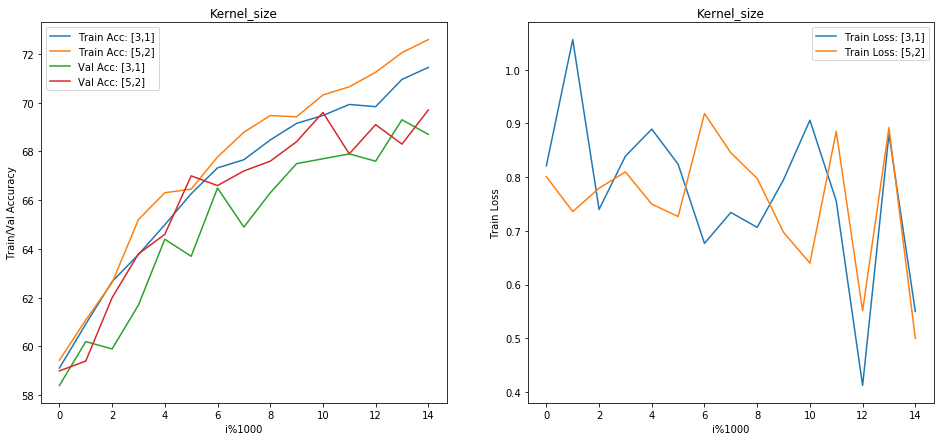

In [26]:
print("----------------------------------BRNN----------------------------------")
plot_curves_biparam(train_acc,train_loss,val_acc,'Kernel_size',kernel_size)

## correct and Incorrect answer in BRNN

In [33]:
correct = []
predicted_list = []
total = 0
test_mode111.eval()
for data1, len1, data2, len2, label in val_loader:
    outputs = F.softmax(test_mode111(data1, len1, data2, len2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct.append(predicted.numpy() == label.view_as(predicted).numpy())
    predicted_list.append(predicted.numpy())
predicted_list = [i for j in range(len(predicted_list)) for i in predicted_list[j] ]
correct = [i for j in range(len(correct)) for i in correct[j] ]

In [34]:
correct_list = []
incorrect_list = []
first_c = True
first_inc = True
counter_c = 0
counter_inc = 0
for i, val in enumerate(correct):
    if counter_c < 3 and val[0] == True:
        if first_c:
            print("-----------correct predictions-------------")
            first_c = False
        print('premise: {}'.format(' '.join(val_sen1[i])))
        print('hypothesis: {}'.format(' '.join(val_sen2[i])))
        print('True label: {}'.format(label_trans(val_y[i])))
        print('\t')
        counter_c += 1
    elif counter_c >= 3 and val[0] == False and counter_inc < 3:
        if first_inc:
            print("-----------incorrect predictions-------------")
            first_inc = False
        print('premise: {}'.format(' '.join(val_sen1[i])))
        print('hypothesis: {}'.format(' '.join(val_sen2[i])))
        print('True label: {}'.format(label_trans(val_y[i])))
        print('But predicted as: {}'.format(label_trans(predicted_list[i])))
        print('\t')
        counter_inc +=1
    elif counter_c >= 3 and counter_inc >= 3:
        break

-----------correct predictions-------------
premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
hypothesis: There are two women standing on the stage
True label: contradiction
	
premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis: Multiple people are on a subway together , with each of them doing their own thing .
True label: entailment
	
premise: bicycles stationed while a group of people socialize .
hypothesis: People get together near a stand of bicycles .
True label: entailment
	
-----------incorrect predictions-------------
premise: Three people and a white dog are sitting in the sand on a beach .
hypothesis: Three dogs and a person are sitting in the snow .
True label: contradiction
But predicted as: neural
	
p

## MultiNLI task

In [39]:
def data_loader_MNLI(filepath):
    sen1 = []
    sen2 = []
    label = []
    genre = []
    with open(filepath)as file:
        f_tsv = csv.reader(file,delimiter = '\t')
        header = next(f_tsv)
        for row in f_tsv:
            sen1.append(row[0].split())
            sen2.append(row[1].split())
            if row[2] == 'contradiction':
                label.append(0.0)
            elif row[2] == 'neutral':
                label.append(1.0)
            elif row[2] == 'entailment':
                label.append(2.0)
            genre.append(row[3])
    return sen1,sen2,label,genre

In [40]:
train_sen1_MNLI, train_sen2_MNLI, train_y_MNLI, train_genre = data_loader_MNLI('hw2_data/mnli_train.tsv')
val_sen1_MNLI, val_sen2_MNLI, val_y_MNLI, val_genre= data_loader_MNLI('hw2_data/mnli_val.tsv')

In [41]:
set(train_genre)

{'fiction', 'government', 'slate', 'telephone', 'travel'}

In [37]:
train_sen1_indices_MNLI = token2index_dataset(train_sen1_MNLI)
train_sen2_indices_MNLI = token2index_dataset(train_sen2_MNLI)
val_sen1_indices_MNLI = token2index_dataset(val_sen1_MNLI)
val_sen2_indices_MNLI = token2index_dataset(val_sen2_MNLI)

In [47]:
MNLI_dict_valsen1 = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[],'all':[]}
MNLI_dict_valsen2 = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[],'all':[]}
MNLI_dict_valy = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[],'all':[]}
for i in range(len(val_genre)):
    MNLI_dict_valsen1[val_genre[i]].append(val_sen1_indices_MNLI[i])
    MNLI_dict_valsen2[val_genre[i]].append(val_sen2_indices_MNLI[i])
    MNLI_dict_valy[val_genre[i]].append(val_y_MNLI[i])
    MNLI_dict_valsen1['all'].append(val_sen1_indices_MNLI[i])
    MNLI_dict_valsen2['all'].append(val_sen2_indices_MNLI[i])
    MNLI_dict_valy['all'].append(val_y_MNLI[i])

In [49]:
best_cnnModel = pkl_loader('test_model4.pkl')

In [57]:
CNNRes = {}
BRNNRes = {}
val_loader_MNLI = {}
for i in ['fiction', 'government', 'slate', 'telephone', 'travel','all']:
    
    val_dataset = SNLI_GroupDataset(MNLI_dict_valsen1[i], MNLI_dict_valsen2[i], MNLI_dict_valy[i])
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)
    val_loader_MNLI[i] = val_loader
    CNNRes[i] = test_model(val_loader, best_cnnModel)
    BRNNRes[i] = test_model(val_loader, test_mode111)
    print('prediction for genre: {}, CNN accuracy {}, BRNN accuracy {}'.format(i,CNNRes[i],BRNNRes[i]))
    

prediction for genre: fiction, CNN accuracy 45.42713567839196, BRNN accuracy 45.7286432160804
prediction for genre: government, CNN accuracy 44.78346456692913, BRNN accuracy 44.68503937007874
prediction for genre: slate, CNN accuracy 41.71656686626746, BRNN accuracy 43.013972055888225
prediction for genre: telephone, CNN accuracy 44.27860696517413, BRNN accuracy 46.865671641791046
prediction for genre: travel, CNN accuracy 44.5010183299389, BRNN accuracy 47.14867617107943
prediction for genre: all, CNN accuracy 44.14, BRNN accuracy 45.48


In [74]:
tableres = pd.concat([ pd.DataFrame(CNNRes, index = ['CNN']),pd.DataFrame(BRNNRes, index = ['BRNN']) ])
tableres

,fiction,government,slate,telephone,travel,all
CNN,45.427136,44.783465,41.716567,44.278607,44.501018,44.14
BRNN,45.728643,44.685039,43.013972,46.865672,47.148676,45.48


## Fine tuning

In [66]:
def train_model_MNLI(model,train_loader, val_loader,learning_rate, num_epochs, model_name='BRNN',genre = ''):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i, (sen1_list, len1, sen2_list, len2, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            out = model(sen1_list, len1,sen2_list,len2)
            loss = criterion(out, label)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
    val_acc = test_model(val_loader, model)
    param_nums = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("--------------------------Model:{} with genre:{}--------------------------".format(model_name,genre))
    print("Number of parameters:{}".format(param_nums))
    print("Val Accuracy:{}".format(val_acc))
    return val_acc

In [59]:
MNLI_dict_trainsen1 = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[]}
MNLI_dict_trainsen2 = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[]}
MNLI_dict_trainy = {'fiction':[], 'government':[], 'slate':[], 'telephone':[], 'travel':[]}
for i in range(len(train_genre)):
    MNLI_dict_trainsen1[train_genre[i]].append(train_sen1_indices_MNLI[i])
    MNLI_dict_trainsen2[train_genre[i]].append(train_sen2_indices_MNLI[i])
    MNLI_dict_trainy[train_genre[i]].append(train_y_MNLI[i])

In [83]:
train_loader_MNLI = {}
for i in ['fiction', 'government', 'slate', 'telephone', 'travel']:    
    train_dataset = SNLI_GroupDataset(MNLI_dict_trainsen1[i], MNLI_dict_trainsen2[i], MNLI_dict_trainy[i])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)
    train_loader_MNLI[i] = train_loader

In [85]:
CNNRes_ft = {}
BRNNRes_ft = {}
for i in ['fiction', 'government', 'slate', 'telephone', 'travel']: 
    BRNNRes_ft[i] = train_model_MNLI(test_mode111,train_loader_MNLI[i],val_loader_MNLI[i],3e-4,5,genre = i)

--------------------------Model:BRNN with genre:fiction--------------------------
Number of parameters:643406
Val Accuracy:54.07035175879397
--------------------------Model:BRNN with genre:government--------------------------
Number of parameters:643406
Val Accuracy:54.42913385826772
--------------------------Model:BRNN with genre:slate--------------------------
Number of parameters:643406
Val Accuracy:48.10379241516966
--------------------------Model:BRNN with genre:telephone--------------------------
Number of parameters:643406
Val Accuracy:54.42786069651741
--------------------------Model:BRNN with genre:travel--------------------------
Number of parameters:643406
Val Accuracy:50.509164969450104


In [79]:
tableres_ft = pd.concat([pd.DataFrame(CNNRes, index = ['CNN']),pd.DataFrame(BRNNRes, index = ['BRNN']),pd.DataFrame(BRNNRes_ft, index = ['BRNN (fine-tuning)']) ])
tableres_ft

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,all,fiction,government,slate,telephone,travel
CNN,44.14,45.427136,44.783465,41.716567,44.278607,44.501018
BRNN,45.48,45.728643,44.685039,43.013972,46.865672,47.148676
BRNN (fine-tuning),NaN,53.869347,54.330709,48.702595,55.820896,53.665988
